In [1]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

import torch
import torch.nn as nn
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri

module_path = os.path.abspath(os.path.join('../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as pilf
import network_utils as nuts

torch.manual_seed(28)

In [2]:
data_bucket = 'sagemaker-us-east-2-362637960691'
train_data_path = 'py-conjugated/m2py_labels/OPV_labels/train_set/'
test_data_path = 'py-conjugated/m2py_labels/OPV_labels/test_set/'
model_states_path = 's3://{}/py_conjugated/model_states/OPV/OPV_encoder_1/'.format(data_bucket)

In [5]:
sagemaker_session = sagemaker.Session()
session_bucket = sagemaker_session.default_bucket()
print(session_bucket)
role = sagemaker.get_execution_role()

# training_image = get_image_uri(sagemaker_session.boto_region_name, 'pytorch', repo_version="latest")

sagemaker-us-east-2-362637960691


In [3]:
%autoreload

train_dataset = nuts.OPV_ImDataset(data_bucket, train_data_path)
test_dataset = nuts.OPV_ImDataset(data_bucket, test_data_path)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 26)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 10)

# torch.save(train_dataloader, './data_loaders/train_data.pth')
# torch.save(test_dataloader, './data_loaders/test_data.pth')

In [4]:
train_inputs = sagemaker_session.upload_data('./data_loaders/train_data.pth',
                                             bucket = session_bucket,
                                             key_prefix = 'OPV-encoder-1')
test_inputs = sagemaker_session.upload_data('./data_loaders/test_data.pth',
                                             bucket = session_bucket,
                                             key_prefix = 'OPV-encoder-1')

NameError: name 'sagemaker_session' is not defined

In [12]:
hp_search_ranges = {
    'lr': ContinuousParameter(0.00001, 0.01),
}

static_hyperparameters = {
    'epochs': 25
}

objective_metric_name = 'test:error'
objective_type = 'Minimize'
metric_definitions = [{'Name': 'test:error','Regex': 'Test MSE = (.*?)'}]
#                       {'Name': 'test:mape', 'Regex': 'Test MAPE = (.*?)'},
#                       {'Name': 'test:r2', 'Regex': 'Test r2 = (.*?)'},]

In [13]:
%autoreload

estimator = PyTorch(entry_point = 'train_test_script.py',
                    source_dir = '../py-conjugated/',
                    hyperparameters = static_hyperparameters,
                    framework_version = '1.5.0',
                    train_instance_count = 1,
                    train_instance_type = 'ml.c4.2xlarge',
                    sagemaker_session = sagemaker_session,
#                     metric_definitions = metric_definitions,
                    role = role,
                    output_path=f's3://{session_bucket}/OPV-encoder-1/output')

In [14]:
tuner = HyperparameterTuner(estimator = estimator,
                            objective_metric_name = objective_metric_name,
                            hyperparameter_ranges = hp_search_ranges,
                            metric_definitions = metric_definitions,
                            objective_type = objective_type,
                            max_jobs = 9,
                            max_parallel_jobs = 1,
                            base_tuning_job_name='OPV-encoder-1',)

In [15]:
tuner.fit({'training': train_inputs, 'validation' : test_inputs}, logs = True, include_cls_metadata=False)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [ ]:
deployed_endpoint = tuner.deploy(
    initial_instance_count = 1,
    instance_type = 'ml.t2.medium'
    update_endpoint = True)

In [ ]:
time_preds = []
time_labels = []
temp_preds = []
temp_labels = []

for ims, labels in test_dataloader.items():
    for i, x, y in enumerate(zip(ims, labels)):
        im_pred, im_enc = deployed_endpoint.predict(x)
        time_preds.append(im_pred[0].item())
        temp_preds.append(im_pred[1].item())
        time_labels.append(y[0].item())
        temp_labels.append(y[1].item())
    
        print(f'Image {i}:')
        print(f'prediction: {im_pred}')
        print(f'label: {y}')
        print('----------------------------')

In [ ]:
mape = pilf.reg_MAPE()

time_mse = mean_squared_error(time_preds, time_labels)
time_r2 = r2_score(time_out, time_labels)
time_mape = mape.forward(time_out, time_labels)

print(f'mse = {time_mse}, mape = {time_mape}, r2 = {time_r2}')

xlin = ylin = np.arange(-20, 20, 1)
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(time_labels, time_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Time Parity')
plt.show()

temp_mse = mean_squared_error(temp_preds, temp_labels)
temp_r2 = r2_score(temp_out, temp_labels)
temp_mape = mape.forward(temp_out, temp_labels)

print(f'mse = {temp_mse}, mape = {temp_mape}, r2 = {temp_r2}')

xlin = ylin = np.arange(-20, 20, 1)
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(temp_labels, temp_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Temperature Parity')
plt.show()

In [ ]:
deployed_endpoint.delete_endpoint()

In [4]:
def fit(model, criterion, lr, epochs = 30):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    train_epoch_pce_losses = []
    train_epoch_voc_losses = []
    train_epoch_jsc_losses = []
    train_epoch_ff_losses = []
    train_loss = []
    
    epoch_pce_losses = []
    epoch_voc_losses = []
    epoch_jsc_losses = []
    epoch_ff_losses = []
    epoch_loss = []
    
    epoch_pce_accs = []
    epoch_voc_accs = []
    epoch_jsc_accs = []
    epoch_ff_accs = []
    epoch_accs = []

    epoch_pce_r2s = []
    epoch_voc_r2s = []
    epoch_jsc_r2s = []
    epoch_ff_r2s = []
    epoch_r2s = []
    
    for epoch in range(epochs):
        train_losses = train.train_OPV_m2py_model(model = model,
                                                training_data_set = train_dataloader,
                                               criterion = criterion,
                                               optimizer = optimizer)

        train_epoch_pce_losses.append(train_losses[0])
        train_epoch_voc_losses.append(train_losses[1])
        train_epoch_jsc_losses.append(train_losses[2])
        train_epoch_ff_losses.append(train_losses[3])
        tot_trn_loss = sum(train_losses)
        train_loss.append(tot_trn_loss)

        test_losses, test_accs, test_r2s = test.eval_OPV_m2py_model(model = model,
                                                                   test_data_set = test_dataloader,
                                                                   criterion = criterion)

        epoch_pce_losses.append(test_losses[0])
        epoch_voc_losses.append(test_losses[1])
        epoch_jsc_losses.append(test_losses[2])
        epoch_ff_losses.append(test_losses[3])
        tot_tst_loss = sum(test_losses)
        epoch_loss.append(tot_tst_loss)
        
        epoch_pce_accs.append(test_accs[0])
        epoch_voc_accs.append(test_accs[1])
        epoch_jsc_accs.append(test_accs[2])
        epoch_ff_accs.append(test_accs[3])
        tot_tst_acc = sum(test_accs)
        epoch_accs.append(tot_tst_acc)
        
        epoch_pce_r2s.append(test_r2s[0])
        epoch_voc_r2s.append(test_r2s[1])
        epoch_jsc_r2s.append(test_r2s[2])
        epoch_ff_r2s.append(test_r2s[3])
        tot_tst_r2 = sum(test_r2s)
        epoch_r2s.append(tot_tst_r2)
        
        print('Finished epoch ', epoch)
        
    best_loss_indx = epoch_loss.index(min(epoch_loss))
    best_acc_indx = epoch_accs.index(min(epoch_accs))
    best_r2_indx = epoch_r2s.index(max(epoch_r2s))
    
    fit_results = {
        'lr': lr,
        'best_loss_epoch': best_loss_indx,
        'best_acc_epoch': best_acc_indx,
        'best_r2_epoch': best_r2_indx,
        'pce_loss': epoch_pce_losses,
        'voc_loss': epoch_voc_losses,
        'jsc_loss': epoch_jsc_losses,
        'ff_loss': epoch_ff_losses,
        'test_losses': epoch_loss,        
        'pce_acc': epoch_pce_accs,
        'voc_acc': epoch_voc_accs,
        'jsc_acc': epoch_jsc_accs,
        'ff_acc': epoch_ff_accs,
        'test_accs': epoch_accs,
        'pce_r2': epoch_pce_r2s,
        'voc_r2': epoch_voc_r2s,
        'jsc_r2': epoch_jsc_r2s,
        'ff_r2': epoch_ff_r2s,
        'test_r2s': epoch_r2s,
        'train_pce_loss': train_epoch_pce_losses,
        'train_voc_loss': train_epoch_voc_losses,
        'train_jsc_loss': train_epoch_jsc_losses,
        'train_ff_loss': train_epoch_ff_losses
    }

    return fit_results

In [5]:
model = net.OPV_m2py_NN(2)
criterion = nn.MSELoss()

lrs = np.linspace(1e-3, 1e-1, 50)

In [6]:
%autoreload

lr_opt = {}

for i, lr in enumerate(lrs):
    print(f'  optimization loop {i}')
    print('-----------------------------')
    
    lr_opt[i] = fit(model, criterion, lr, epochs = 15)


  optimization loop 0
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 1
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 2
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 3
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 4
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 5
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 6
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 7
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 8
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 9
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 10
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 11
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 12
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 13
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 14
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 15
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 16
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 17
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 18
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 19
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 20
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 21
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 22
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 23
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 24
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 25
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 26
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 27
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 28
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 29
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 30
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 31
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 32
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 33
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 34
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 35
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 36
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 37
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 38
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 39
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 40
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 41
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 42
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 43
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 44
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 45
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 46
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 47
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 48
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14
  optimization loop 49
-----------------------------
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  0
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  1
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  2
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  3
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  4
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  5
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  6
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  7
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  8
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  9
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  10
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  11
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  12
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  13
training batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


testing batch # 1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished epoch  14


In [7]:
lr_opt

{0: {'lr': 0.001,
  'best_loss_epoch': 8,
  'best_acc_epoch': 8,
  'best_r2_epoch': 8,
  'pce_loss': [125201072.0,
   98951.328125,
   22.584341049194336,
   20.743799209594727,
   16.575908660888672,
   10.978650093078613,
   5.3791890144348145,
   1.3377633094787598,
   0.7217903733253479,
   0.7221508622169495,
   0.7224739789962769,
   0.7227644920349121,
   0.7230265736579895,
   0.7232633233070374,
   0.7234775424003601],
  'voc_loss': [250401792.0,
   197893.28125,
   45.28456115722656,
   41.5976448059082,
   33.2475528717041,
   22.030502319335938,
   10.801854133605957,
   2.683863401412964,
   1.4426528811454773,
   1.4433805346488953,
   1.4440327286720276,
   1.4446189999580383,
   1.4451478123664856,
   1.445625364780426,
   1.4460577368736267],
  'jsc_loss': [125200760.0,
   98942.4375,
   22.709543228149414,
   20.86347007751465,
   16.681991577148438,
   11.06334114074707,
   5.435666561126709,
   1.3608851432800293,
   0.7361180186271667,
   0.7364850044250488,
   0.7

In [8]:
import json

In [9]:
#with open('s3://sagemaker-us-east-2-362637960691/20200722_CNN3_hpo_results.json', 'w') as fp:
with open('./20200722_CNN3_hpo_results.json', 'w') as fp:
    json.dump(lr_opt, fp)

In [ ]:
def plot_test_losses(lr_opt):
    for key, trial in lr_opt.items():
        

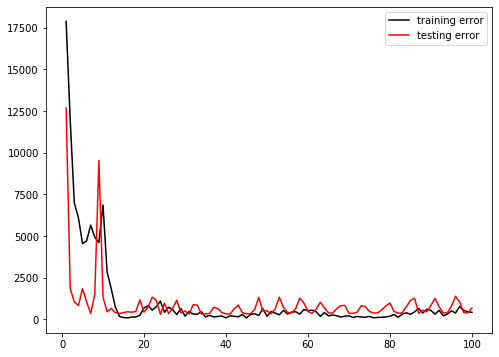

In [8]:
%autoreload
epochs = np.arange(1, (num_epochs+1), 1)

nuts.plot_OPV_df_loss(epochs, train_epoch_losses, test_epoch_losses,
                     pce_train_epoch_losses, pce_test_epoch_losses,
                     voc_train_epoch_losses, voc_test_epoch_losses,
                     jsc_train_epoch_losses, jsc_test_epoch_losses,
                     ff_train_epoch_losses, ff_test_epoch_losses)

nuts.plot_OPV_df_accuracies(epochs, pce_test_epoch_accuracies, voc_test_epoch_accuracies, 
                           jsc_test_epoch_accuracies, ff_test_epoch_accuracies)

In [ ]:
avg_acc = []
for p, v, j, f in zip(pce_test_epoch_accuracies, voc_test_epoch_accuracies,
                      jsc_test_epoch_accuracies, ff_test_epoch_accuracies):
    
    acc = (p+v+j+f)/4
    avg_acc.append(acc)
    
fig, ax = plt.subplots()
plt.plot(epochs, avg_acc)
plt.title('Average MAPE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute % Error')
plt.show()

In [ ]:
potential_models = avg_acc[:45]

min_mape = min(potential_models)

best_acc_indx = []
for acc in potential_models:
    if acc == min_mape:
        best_acc_indx.append(potential_models.index(acc))
    else:
        pass

In [ ]:
if best_acc_indx[0] < 10:
    epoch = f'0{best_acc_indx[0]}'
else:
    epoch = f'{best_acc_indx[0]}'

print(epoch)

best_model_path = save_dir + model_name + '_epoch' + epoch + '.pt'
best_model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)

best_model, best_optimizer = nuts.load_trained_model(best_model_path, best_model, optimizer)

In [ ]:
%autoreload

best_model.eval()

with torch.no_grad():
    for inputs, pce_labels, voc_labels, jsc_labels, ff_labels in testing_data_set:
        inputs = inputs.to(device)
        pce_labels = pce_labels.to(device)
        voc_labels = voc_labels.to(device)
        jsc_labels = jsc_labels.to(device)
        ff_labels = ff_labels.to(device)

        PCE_out, Voc_out, Jsc_out, FF_out = best_model(inputs)
        

mape = pilf.reg_MAPE()

pce_mse = mean_squared_error(PCE_out, pce_labels)
pce_r2 = r2_score(PCE_out, pce_labels)
pce_mape = mape.forward(PCE_out, pce_labels)

print(f'mse = {pce_mse}, mape = {pce_mape}, r2 = {pce_r2}')

voc_mse = mean_squared_error(Voc_out, voc_labels)
voc_r2 = r2_score(Voc_out, voc_labels)
voc_mape = mape.forward(Voc_out, voc_labels)

print(f'mse = {voc_mse}, mape = {voc_mape}, r2 = {voc_r2}')

jsc_mse = mean_squared_error(Jsc_out, jsc_labels)
jsc_r2 = r2_score(Jsc_out, jsc_labels)
jsc_mape = mape.forward(Jsc_out, jsc_labels)

print(f'mse = {jsc_mse}, mape = {jsc_mape}, r2 = {jsc_r2}')

ff_mse = mean_squared_error(FF_out, ff_labels)
ff_r2 = r2_score(FF_out, ff_labels)
ff_mape = mape.forward(FF_out, ff_labels)

print(f'mse = {ff_mse}, mape = {ff_mape}, r2 = {ff_r2}')

In [ ]:
%autoreload

nuts.plot_OPV_parity(pce_labels, PCE_out, voc_labels, Voc_out, jsc_labels, Jsc_out, ff_labels, FF_out)